# Task 3.1: Model Explainability - E-commerce Fraud Detection

## Objective
Explain model predictions using SHAP (SHapley Additive exPlanations):
1. **Global explainability**: Which features matter most overall?
2. **Local explainability**: Why did the model flag specific transactions?

## Why Explainability Matters
- **Regulatory compliance**: Many jurisdictions require explanations for automated decisions
- **Trust**: Business stakeholders need to understand model behavior
- **Debugging**: Identify if model relies on spurious correlations
- **Actionable insights**: Translate model patterns into business rules

In [1]:
# Standard imports
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import shap
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

# Project imports
from src.explainability.shap_utils import (
    get_feature_names_from_pipeline,
    transform_for_explanation,
    create_tree_explainer,
    compute_shap_values,
    plot_shap_summary,
    plot_shap_bar,
    plot_shap_dependence,
    plot_shap_waterfall,
    get_example_cases,
)

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

# Initialize SHAP JS visualization
shap.initjs()

RANDOM_STATE = 42

## 1. Load Model and Data

In [2]:
# Load the best model (Random Forest)
MODEL_PATH = project_root / "models" / "fraud_random_forest.joblib"

model = joblib.load(MODEL_PATH)
print(f"Loaded model from: {MODEL_PATH}")
print(f"Pipeline steps: {list(model.named_steps.keys())}")

Loaded model from: /Users/macbookpro/Documents/Fraud-Detection-system/models/fraud_random_forest.joblib
Pipeline steps: ['preprocessor', 'smote', 'classifier']


In [3]:
# Load feature-engineered data
DATA_PATH = project_root / "data" / "processed" / "fraud_featured.parquet"

df = pd.read_parquet(DATA_PATH)
print(f"Loaded data: {df.shape}")

Loaded data: (151112, 22)


In [4]:
# Define features (same as Task 2)
NUMERIC_FEATURES = [
    'purchase_value', 'age', 'hour_of_day', 'day_of_week', 'is_weekend',
    'time_since_signup', 'tx_count_user_id_1h', 'tx_count_user_id_24h',
    'user_total_transactions'
]

CATEGORICAL_FEATURES = ['source', 'browser', 'sex', 'country']

TARGET = 'class'

X = df[NUMERIC_FEATURES + CATEGORICAL_FEATURES].copy()
y = df[TARGET].copy()

print(f"Features: {X.shape[1]}")
print(f"Target distribution: {y.value_counts().to_dict()}")

Features: 13
Target distribution: {0: 136961, 1: 14151}


In [5]:
# Recreate the same train/test split as Task 2
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"Test set size: {X_test.shape[0]:,}")

Test set size: 30,223


## 2. Prepare for SHAP Analysis

In [6]:
# Get feature names after preprocessing (including one-hot encoded)
feature_names = get_feature_names_from_pipeline(
    model,
    NUMERIC_FEATURES,
    CATEGORICAL_FEATURES
)

print(f"Total features after encoding: {len(feature_names)}")
print(f"\nFirst 20 feature names:")
print(feature_names[:20])

Total features after encoding: 198

First 20 feature names:
['purchase_value', 'age', 'hour_of_day', 'day_of_week', 'is_weekend', 'time_since_signup', 'tx_count_user_id_1h', 'tx_count_user_id_24h', 'user_total_transactions', 'source_Ads', 'source_Direct', 'source_SEO', 'browser_Chrome', 'browser_FireFox', 'browser_IE', 'browser_Opera', 'browser_Safari', 'sex_F', 'sex_M', 'country_Afghanistan']


In [7]:
# Transform test data for SHAP (using only preprocessor, not SMOTE)
X_test_transformed = transform_for_explanation(model, X_test)

print(f"Transformed test data shape: {X_test_transformed.shape}")

Transformed test data shape: (30223, 198)


In [8]:
# Create SHAP explainer for the Random Forest classifier
explainer = create_tree_explainer(model)

print(f"Explainer type: {type(explainer)}")

Explainer type: <class 'shap.explainers._tree.TreeExplainer'>


In [9]:
# Compute SHAP values (sample for speed)
# For large datasets, we sample to speed up computation
SAMPLE_SIZE = 5000  # Adjust based on dataset size and available time

print(f"Computing SHAP values for {min(SAMPLE_SIZE, len(X_test_transformed)):,} samples...")
print("(This may take a few minutes)")

shap_values = compute_shap_values(
    explainer,
    X_test_transformed,
    sample_size=SAMPLE_SIZE,
    random_state=RANDOM_STATE
)

print(f"SHAP values computed: {shap_values.values.shape}")

Computing SHAP values for 5,000 samples...
(This may take a few minutes)
SHAP values computed: (5000, 198, 2)


## 3. Global Explainability

### 3.1 SHAP Summary Plot (Beeswarm)

Saved: /Users/macbookpro/Documents/Fraud-Detection-system/reports/figures/shap_summary_fraud.png


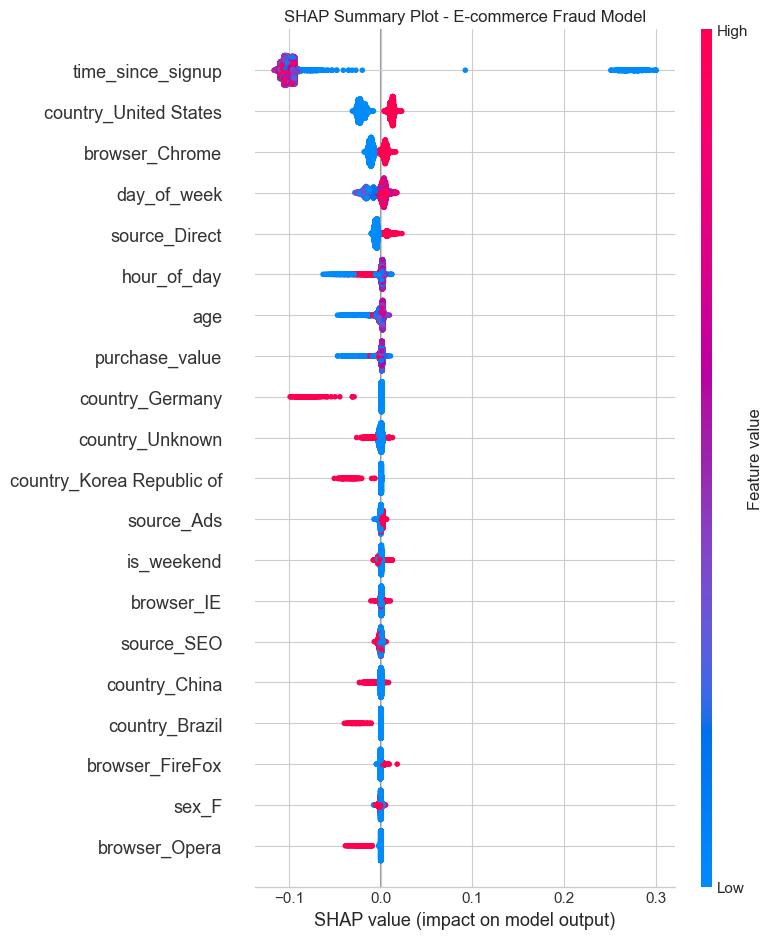

In [10]:
# Summary plot showing feature impact distribution
plot_shap_summary(
    shap_values,
    feature_names,
    max_display=20,
    plot_type="dot",
    title="SHAP Summary Plot - E-commerce Fraud Model",
    save_path=project_root / "reports" / "figures" / "shap_summary_fraud.png"
)

In [11]:
from IPython.display import Markdown, display

# Get top features for interpretation
# SHAP can return values with shape:
# - (n_samples, n_features)
# - (n_samples, n_classes, n_features) for classifiers
# - (n_samples, n_features, n_classes) in some SHAP versions
vals = np.asarray(shap_values.values)

if vals.ndim == 3:
    # Prefer positive class (fraud=1) if available
    if vals.shape[-1] == len(feature_names):
        # Likely (n_samples, n_outputs/classes, n_features)
        if vals.shape[1] >= 2:
            vals_2d = vals[:, 1, :]
        else:
            vals_2d = vals[:, 0, :]
    elif vals.shape[1] == len(feature_names):
        # Likely (n_samples, n_features, n_outputs/classes)
        if vals.shape[2] >= 2:
            vals_2d = vals[:, :, 1]
        else:
            vals_2d = vals[:, :, 0]
    else:
        # Fallback: flatten all but samples
        vals_2d = vals.reshape(vals.shape[0], -1)
elif vals.ndim == 2:
    vals_2d = vals
else:
    raise ValueError(f"Unexpected SHAP values shape: {vals.shape}")

mean_abs_shap = np.abs(vals_2d).mean(axis=0)
top_indices = np.argsort(mean_abs_shap)[-5:][::-1].astype(int).tolist()
top_features = [feature_names[i] for i in top_indices]

display(
    Markdown(
        f"""
### Interpretation: SHAP Summary Plot

The beeswarm plot shows how each feature impacts model predictions:
- **X-axis**: SHAP value (positive = pushes toward fraud, negative = pushes toward non-fraud)
- **Color**: Feature value (red = high, blue = low)
- **Each dot**: One transaction

**Top 5 most impactful features**:
1. `{top_features[0]}`
2. `{top_features[1]}`
3. `{top_features[2]}`
4. `{top_features[3]}`
5. `{top_features[4]}`

**Key patterns to look for**:
- If `time_since_signup` shows red (high values) pushing left (non-fraud), it means established accounts are less risky.
- If velocity features (`tx_count_*`) show red pushing right, high transaction frequency indicates fraud.
"""
    )
)


### Interpretation: SHAP Summary Plot

The beeswarm plot shows how each feature impacts model predictions:
- **X-axis**: SHAP value (positive = pushes toward fraud, negative = pushes toward non-fraud)
- **Color**: Feature value (red = high, blue = low)
- **Each dot**: One transaction

**Top 5 most impactful features**:
1. `time_since_signup`
2. `country_United States`
3. `browser_Chrome`
4. `day_of_week`
5. `source_Direct`

**Key patterns to look for**:
- If `time_since_signup` shows red (high values) pushing left (non-fraud), it means established accounts are less risky.
- If velocity features (`tx_count_*`) show red pushing right, high transaction frequency indicates fraud.


### 3.2 SHAP Feature Importance (Bar Plot)

Saved: /Users/macbookpro/Documents/Fraud-Detection-system/reports/figures/shap_importance_fraud.png


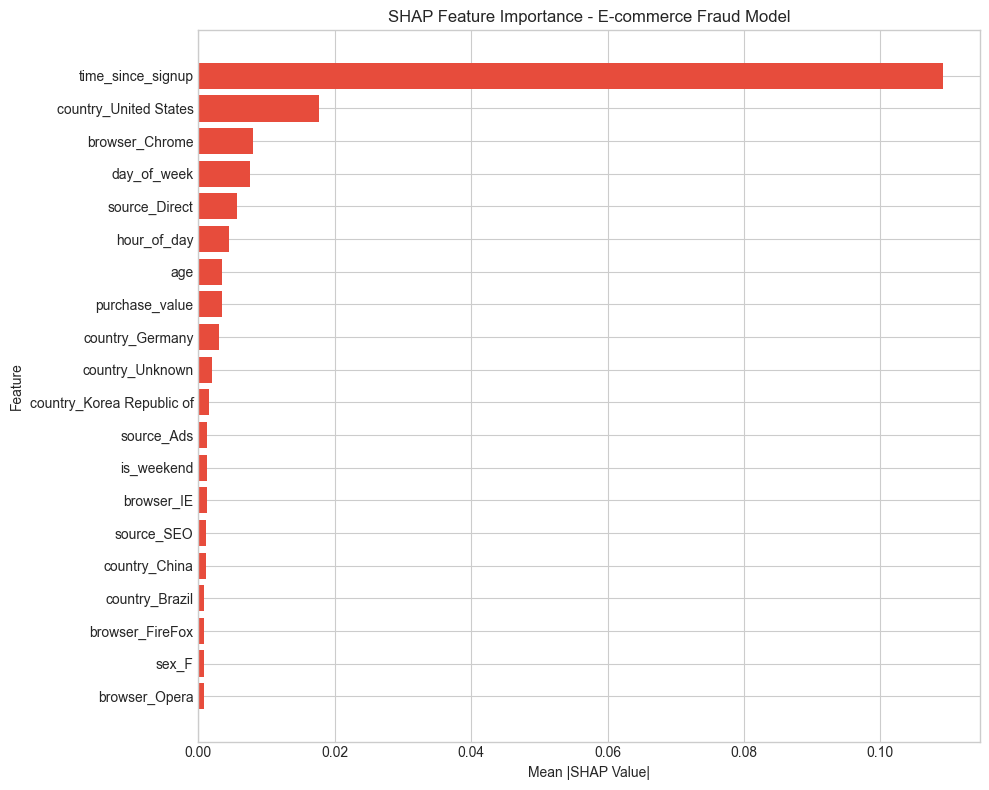

In [12]:
# Bar plot of mean absolute SHAP values
importance_df = plot_shap_bar(
    shap_values,
    feature_names,
    max_display=20,
    title="SHAP Feature Importance - E-commerce Fraud Model",
    save_path=project_root / "reports" / "figures" / "shap_importance_fraud.png"
)

In [13]:
# Show top features table
print("Top 15 Features by SHAP Importance:")
display(importance_df.head(15).round(4))

Top 15 Features by SHAP Importance:


,feature,mean_abs_shap
5,time_since_signup,0.1092
187,country_United States,0.0177
12,browser_Chrome,0.0080
3,day_of_week,0.0076
10,source_Direct,0.0057
2,hour_of_day,0.0045
1,age,0.0035
0,purchase_value,0.0034
82,country_Germany,0.0031
188,country_Unknown,0.0020


### 3.3 SHAP Dependence Plots

Dependence plot for top numeric feature: time_since_signup
Saved: /Users/macbookpro/Documents/Fraud-Detection-system/reports/figures/shap_dependence_time_since_signup.png


<Figure size 1000x600 with 0 Axes>

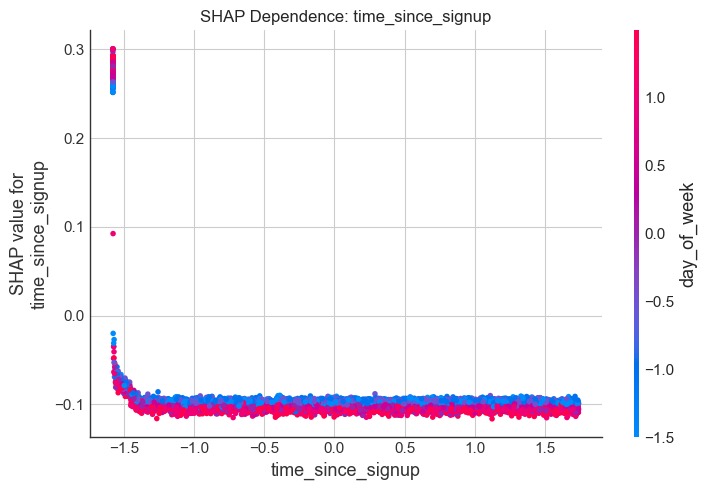

In [14]:
# Dependence plot for top numeric feature
# Find the top numeric feature from our original list
top_numeric = None
for feat in importance_df['feature'].values:
    if feat in NUMERIC_FEATURES:
        top_numeric = feat
        break

if top_numeric:
    print(f"Dependence plot for top numeric feature: {top_numeric}")
    plot_shap_dependence(
        shap_values,
        top_numeric,
        feature_names,
        title=f"SHAP Dependence: {top_numeric}",
        save_path=project_root / "reports" / "figures" / f"shap_dependence_{top_numeric}.png"
    )

Saved: /Users/macbookpro/Documents/Fraud-Detection-system/reports/figures/shap_dependence_time_since_signup.png


<Figure size 1000x600 with 0 Axes>

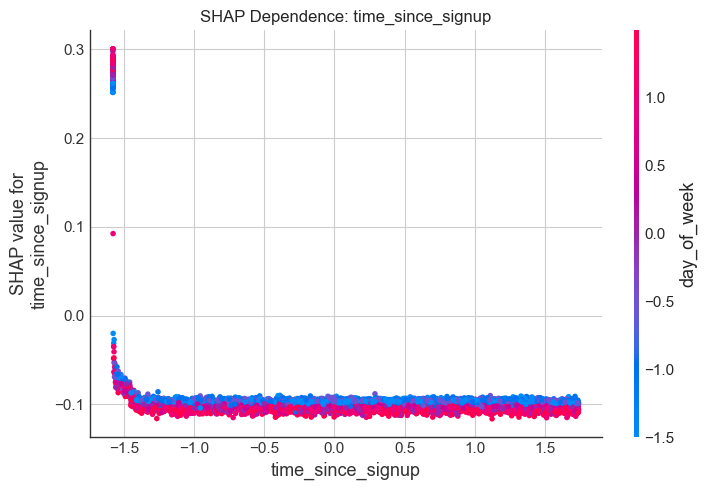

In [15]:
# Dependence plot for time_since_signup (often very important for fraud)
if 'time_since_signup' in feature_names:
    plot_shap_dependence(
        shap_values,
        'time_since_signup',
        feature_names,
        title="SHAP Dependence: time_since_signup",
        save_path=project_root / "reports" / "figures" / "shap_dependence_time_since_signup.png"
    )

Saved: /Users/macbookpro/Documents/Fraud-Detection-system/reports/figures/shap_dependence_velocity_1h.png


<Figure size 1000x600 with 0 Axes>

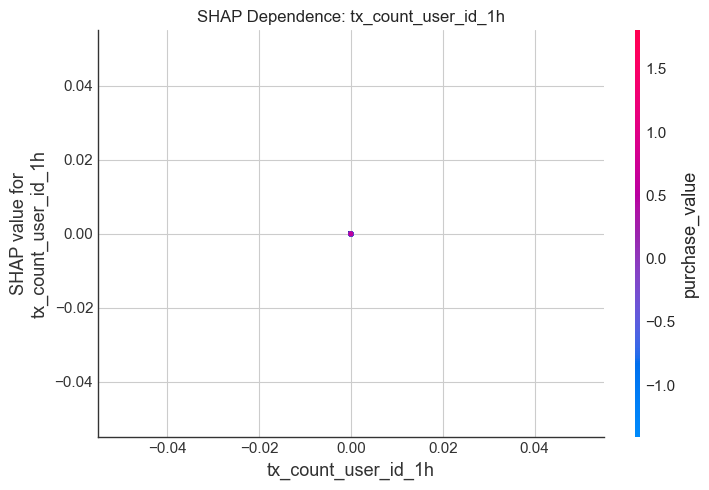

In [16]:
# Dependence plot for transaction velocity
if 'tx_count_user_id_1h' in feature_names:
    plot_shap_dependence(
        shap_values,
        'tx_count_user_id_1h',
        feature_names,
        title="SHAP Dependence: tx_count_user_id_1h",
        save_path=project_root / "reports" / "figures" / "shap_dependence_velocity_1h.png"
    )

In [17]:
from IPython.display import Markdown, display

display(
    Markdown(
        """
### Interpretation: Dependence Plots

Dependence plots show how a feature's value relates to its SHAP impact:

**Common patterns in fraud detection:**
- **`time_since_signup`**: Very short times (seconds/minutes) often show high positive SHAP (fraud signal). Established accounts show negative SHAP (safe signal).
- **`tx_count_user_id_1h`**: Multiple transactions in 1 hour typically push predictions toward fraud.
- **`purchase_value`**: May show non-linear patterns (both very low and very high amounts can be suspicious).

**Business translation:**
- New accounts making rapid transactions are flagged as high risk.
- This validates our feature engineering choices in Task 1.
"""
    )
)


### Interpretation: Dependence Plots

Dependence plots show how a feature's value relates to its SHAP impact:

**Common patterns in fraud detection:**
- **`time_since_signup`**: Very short times (seconds/minutes) often show high positive SHAP (fraud signal). Established accounts show negative SHAP (safe signal).
- **`tx_count_user_id_1h`**: Multiple transactions in 1 hour typically push predictions toward fraud.
- **`purchase_value`**: May show non-linear patterns (both very low and very high amounts can be suspicious).

**Business translation:**
- New accounts making rapid transactions are flagged as high risk.
- This validates our feature engineering choices in Task 1.


## 4. Local Explainability (Individual Predictions)

In [18]:
# Get predictions on test set
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(f"Predictions made: {len(y_pred):,}")

Predictions made: 30,223


In [19]:
# Get example cases for each outcome type
example_cases = get_example_cases(
    y_test.values,
    y_pred,
    y_proba,
    n_examples=3
)

print("Example cases found:")
for case_type, indices in example_cases.items():
    print(f"  {case_type}: {len(indices)} examples")

Example cases found:
  true_positive: 3 examples
  false_positive: 3 examples
  false_negative: 3 examples
  true_negative: 3 examples


In [20]:
# Compute SHAP values for all test samples (needed for waterfall plots)
# We'll use the full test set for local explanations
print("Computing SHAP values for local explanations...")
shap_values_full = explainer(X_test_transformed)
print("Done.")

Computing SHAP values for local explanations...
Done.


### 4.1 True Positive: Correctly Caught Fraud

True Positive Example (index 19760):
  Actual: Fraud | Predicted: Fraud | Probability: 0.8362

Key feature values:
  purchase_value: 11
  age: 32
  hour_of_day: 18
  day_of_week: 6
  is_weekend: 1


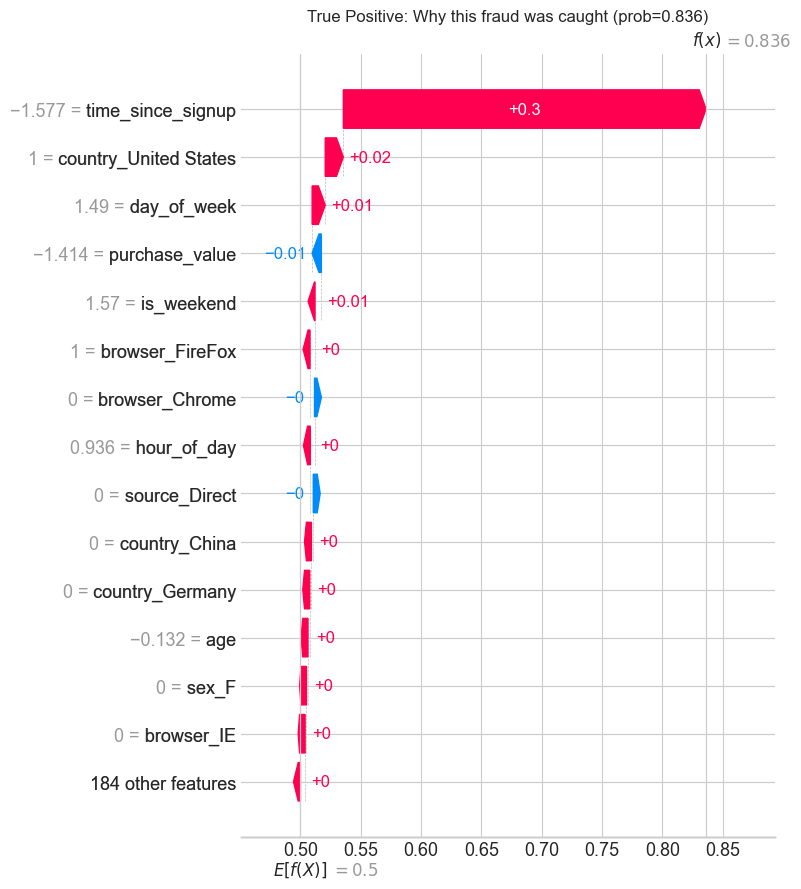

In [21]:
# Explain a True Positive case
if example_cases['true_positive']:
    tp_idx = example_cases['true_positive'][0]
    
    print(f"True Positive Example (index {tp_idx}):")
    print(f"  Actual: Fraud | Predicted: Fraud | Probability: {y_proba[tp_idx]:.4f}")
    print(f"\nKey feature values:")
    for feat in NUMERIC_FEATURES[:5]:
        print(f"  {feat}: {X_test.iloc[tp_idx][feat]}")
    
    plot_shap_waterfall(
        shap_values_full,
        tp_idx,
        feature_names,
        max_display=15,
        title=f"True Positive: Why this fraud was caught (prob={y_proba[tp_idx]:.3f})",
    )
else:
    print("No True Positive examples found.")

### 4.2 False Positive: Incorrectly Flagged Legitimate Transaction

False Positive Example (index 21664):
  Actual: Legitimate | Predicted: Fraud | Probability: 0.7997

Key feature values:
  purchase_value: 54
  age: 34
  hour_of_day: 5
  day_of_week: 5
  is_weekend: 1


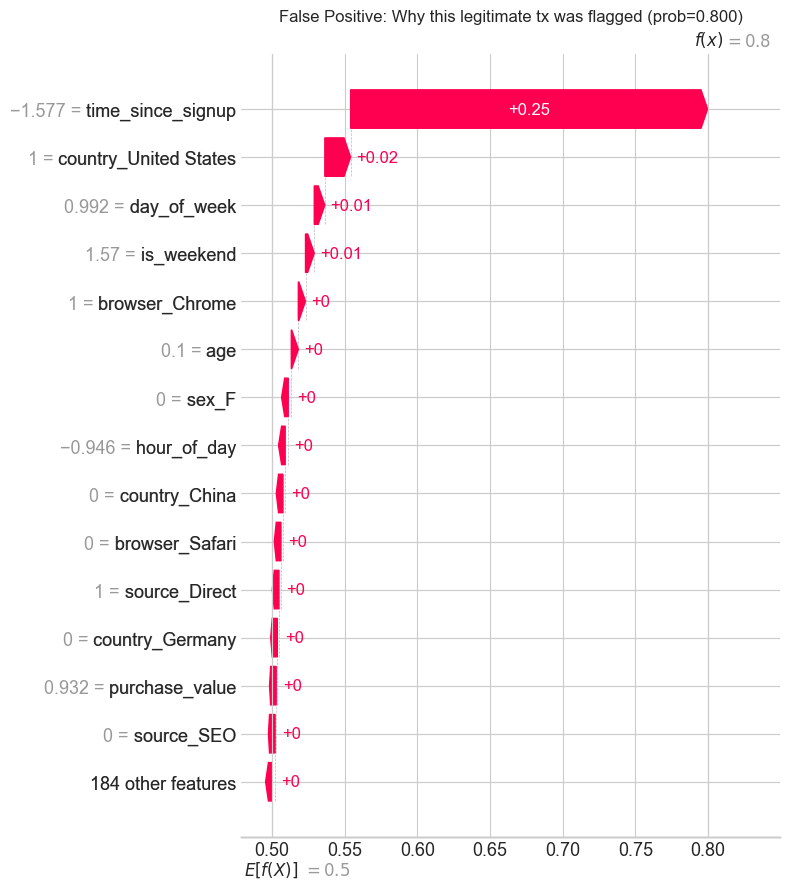

In [22]:
# Explain a False Positive case
if example_cases['false_positive']:
    fp_idx = example_cases['false_positive'][0]
    
    print(f"False Positive Example (index {fp_idx}):")
    print(f"  Actual: Legitimate | Predicted: Fraud | Probability: {y_proba[fp_idx]:.4f}")
    print(f"\nKey feature values:")
    for feat in NUMERIC_FEATURES[:5]:
        print(f"  {feat}: {X_test.iloc[fp_idx][feat]}")
    
    plot_shap_waterfall(
        shap_values_full,
        fp_idx,
        feature_names,
        max_display=15,
        title=f"False Positive: Why this legitimate tx was flagged (prob={y_proba[fp_idx]:.3f})",
    )
else:
    print("No False Positive examples found.")

### 4.3 False Negative: Missed Fraud

False Negative Example (index 3913):
  Actual: Fraud | Predicted: Legitimate | Probability: 0.2274

Key feature values:
  purchase_value: 10
  age: 52
  hour_of_day: 14
  day_of_week: 6
  is_weekend: 1


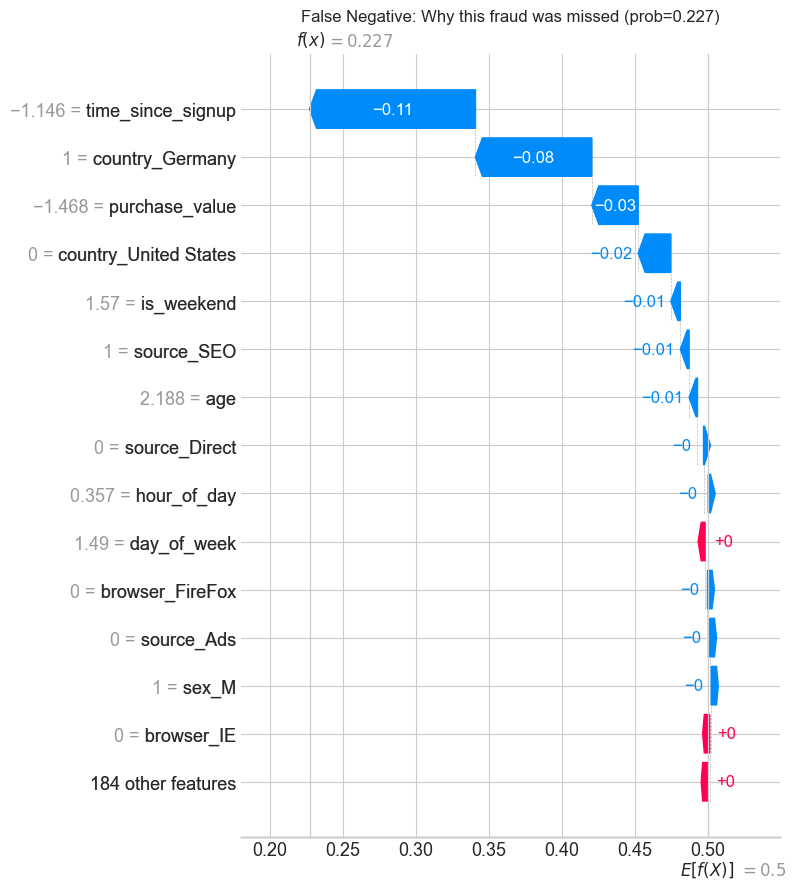

In [23]:
# Explain a False Negative case
if example_cases['false_negative']:
    fn_idx = example_cases['false_negative'][0]
    
    print(f"False Negative Example (index {fn_idx}):")
    print(f"  Actual: Fraud | Predicted: Legitimate | Probability: {y_proba[fn_idx]:.4f}")
    print(f"\nKey feature values:")
    for feat in NUMERIC_FEATURES[:5]:
        print(f"  {feat}: {X_test.iloc[fn_idx][feat]}")
    
    plot_shap_waterfall(
        shap_values_full,
        fn_idx,
        feature_names,
        max_display=15,
        title=f"False Negative: Why this fraud was missed (prob={y_proba[fn_idx]:.3f})",
    )
else:
    print("No False Negative examples found.")

In [24]:
from IPython.display import Markdown, display

display(
    Markdown(
        """
### Interpretation: Local Explanations

**Waterfall plots** show how each feature pushed the prediction from the baseline (average) toward the final output:

- **Red bars**: Features pushing toward fraud prediction
- **Blue bars**: Features pushing toward legitimate prediction
- **E[f(X)]**: Expected value (baseline)
- **f(x)**: Final prediction value

**What we learn from each case type:**

1. **True Positives**: Validate that the model catches fraud for the right reasons (e.g., new account + high velocity)

2. **False Positives**: Understand why legitimate transactions look suspicious. This helps:
   - Refine features
   - Adjust threshold
   - Design better customer experience for flagged transactions

3. **False Negatives**: Critical for understanding model blindspots. Fraudsters that "look normal" reveal feature gaps.
"""
    )
)


### Interpretation: Local Explanations

**Waterfall plots** show how each feature pushed the prediction from the baseline (average) toward the final output:

- **Red bars**: Features pushing toward fraud prediction
- **Blue bars**: Features pushing toward legitimate prediction
- **E[f(X)]**: Expected value (baseline)
- **f(x)**: Final prediction value

**What we learn from each case type:**

1. **True Positives**: Validate that the model catches fraud for the right reasons (e.g., new account + high velocity)

2. **False Positives**: Understand why legitimate transactions look suspicious. This helps:
   - Refine features
   - Adjust threshold
   - Design better customer experience for flagged transactions

3. **False Negatives**: Critical for understanding model blindspots. Fraudsters that "look normal" reveal feature gaps.


## 5. Summary: Task 3 (E-commerce) Complete

In [25]:
from IPython.display import Markdown, display

top5_str = "\n".join([f"{i+1}. `{f}` (mean |SHAP| = {importance_df.iloc[i]['mean_abs_shap']:.4f})" 
                       for i, f in enumerate(importance_df.head(5)['feature'])])

display(
    Markdown(
        f"""
## Summary: Task 3 - E-commerce Fraud Model Explainability

### Global Insights

**Top 5 most important features by SHAP:**
{top5_str}

### Key Findings

1. **Time-based features** (e.g., `time_since_signup`) are strong fraud indicators.
   - New accounts are riskier.
   - This aligns with known fraud patterns (create-and-use attacks).

2. **Velocity features** (e.g., `tx_count_user_id_1h`) capture behavioral fraud signals.
   - High transaction frequency in short windows indicates automated fraud.

3. **Geographic features** (country-related) may show regional fraud patterns.
   - Useful for risk-based authentication.

### Business Recommendations

Based on SHAP analysis:
- **Step-up authentication** for new accounts (< threshold time since signup)
- **Velocity limits** or additional verification for rapid transactions
- **Geographic risk scoring** integrated with payment flow

### Files Saved
- `reports/figures/shap_summary_fraud.png`
- `reports/figures/shap_importance_fraud.png`
- `reports/figures/shap_dependence_*.png`

### Next Steps
- Run `07_shap_explainability_creditcard.ipynb` for credit card model
- Use insights to refine feature engineering or business rules
- Consider deploying model with real-time SHAP explanations for flagged transactions
"""
    )
)


## Summary: Task 3 - E-commerce Fraud Model Explainability

### Global Insights

**Top 5 most important features by SHAP:**
1. `time_since_signup` (mean |SHAP| = 0.1092)
2. `country_United States` (mean |SHAP| = 0.0177)
3. `browser_Chrome` (mean |SHAP| = 0.0080)
4. `day_of_week` (mean |SHAP| = 0.0076)
5. `source_Direct` (mean |SHAP| = 0.0057)

### Key Findings

1. **Time-based features** (e.g., `time_since_signup`) are strong fraud indicators.
   - New accounts are riskier.
   - This aligns with known fraud patterns (create-and-use attacks).

2. **Velocity features** (e.g., `tx_count_user_id_1h`) capture behavioral fraud signals.
   - High transaction frequency in short windows indicates automated fraud.

3. **Geographic features** (country-related) may show regional fraud patterns.
   - Useful for risk-based authentication.

### Business Recommendations

Based on SHAP analysis:
- **Step-up authentication** for new accounts (< threshold time since signup)
- **Velocity limits** or additional verification for rapid transactions
- **Geographic risk scoring** integrated with payment flow

### Files Saved
- `reports/figures/shap_summary_fraud.png`
- `reports/figures/shap_importance_fraud.png`
- `reports/figures/shap_dependence_*.png`

### Next Steps
- Run `07_shap_explainability_creditcard.ipynb` for credit card model
- Use insights to refine feature engineering or business rules
- Consider deploying model with real-time SHAP explanations for flagged transactions
